In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


Dataset shape: (23195, 130)

Countries: 314
Years: 1900 - 2024
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23195 entries, 0 to 23194
Columns: 130 entries, country to wind_share_energy
dtypes: float64(127), int64(1), object(2)
memory usage: 23.0+ MB


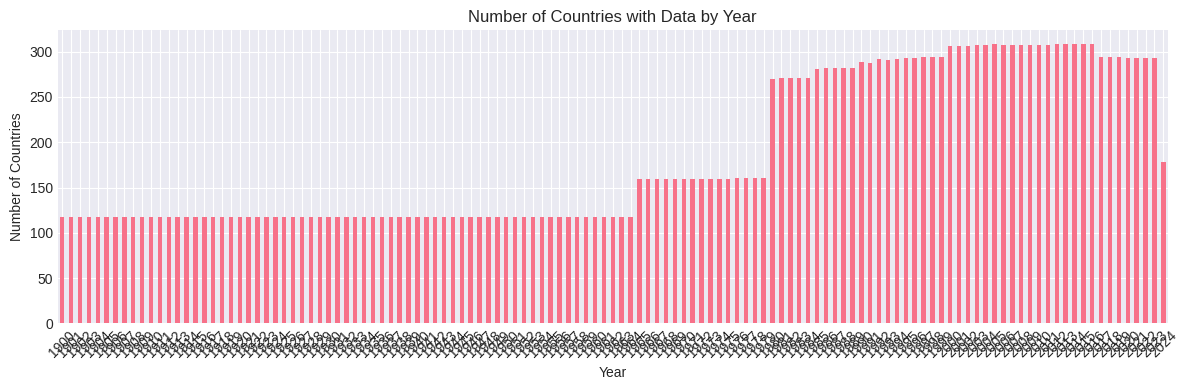

In [3]:
# Load the data
df = pd.read_csv('owid-energy-data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nCountries: {df['country'].nunique()}")
print(f"Years: {df['year'].min()} - {df['year'].max()}")

# Display basic info
df.info()
# Check data coverage by year
yearly_counts = df.groupby('year')['country'].count()
plt.figure(figsize=(12, 4))
yearly_counts.plot(kind='bar')
plt.title('Number of Countries with Data by Year')
plt.xlabel('Year')
plt.ylabel('Number of Countries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Transition features created for 308 countries


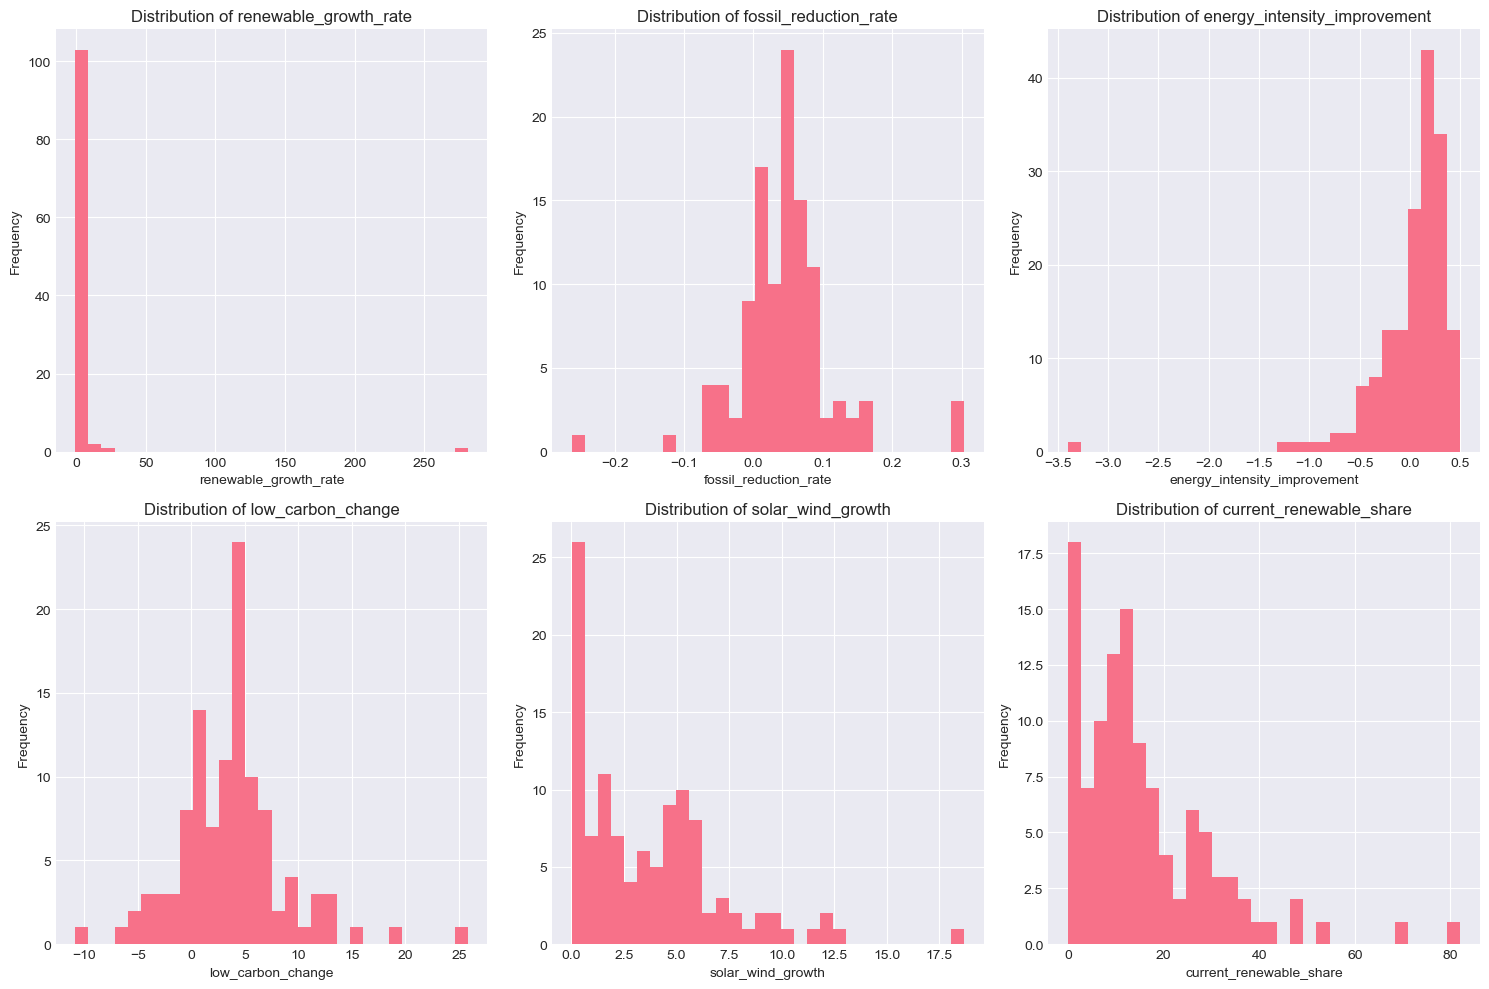

In [8]:
## 3. Feature Engineering

def create_transition_features(df, start_year=2010, end_year=2022):
    """
    Create energy transition features for clustering
    Focus on recent transition patterns (2010-2022)
    """
    
    # Filter data for the analysis period
    df_period = df[(df['year'] >= start_year) & (df['year'] <= end_year)].copy()
    
    # Calculate country-level transition metrics
    transition_features = []
    
    for country in df_period['country'].unique():
        country_data = df_period[df_period['country'] == country].sort_values('year')
        
        if len(country_data) < 5:  # Skip countries with insufficient data
            continue
            
        features = {'country': country}
        
        # 1. Renewable energy growth rate
        renewable_start = country_data['renewables_share_energy'].iloc[0]
        renewable_end = country_data['renewables_share_energy'].iloc[-1]
        if pd.notna(renewable_start) and renewable_start > 0:
            features['renewable_growth_rate'] = (renewable_end - renewable_start) / renewable_start
        else:
            features['renewable_growth_rate'] = np.nan
            
        # 2. Fossil fuel reduction rate
        fossil_start = country_data['fossil_share_energy'].iloc[0]
        fossil_end = country_data['fossil_share_energy'].iloc[-1]
        if pd.notna(fossil_start) and fossil_start > 0:
            features['fossil_reduction_rate'] = (fossil_start - fossil_end) / fossil_start
        else:
            features['fossil_reduction_rate'] = np.nan
            
        # 3. Energy intensity improvement
        energy_intensity_start = country_data['energy_per_gdp'].iloc[0]
        energy_intensity_end = country_data['energy_per_gdp'].iloc[-1]
        if pd.notna(energy_intensity_start) and energy_intensity_start > 0:
            features['energy_intensity_improvement'] = (energy_intensity_start - energy_intensity_end) / energy_intensity_start
        else:
            features['energy_intensity_improvement'] = np.nan
            
        # 4. Low carbon share change
        low_carbon_start = country_data['low_carbon_share_energy'].iloc[0]
        low_carbon_end = country_data['low_carbon_share_energy'].iloc[-1]
        features['low_carbon_change'] = low_carbon_end - low_carbon_start if pd.notna(low_carbon_start) else np.nan
        
        # 5. Solar and wind adoption rate
        solar_wind_start = (country_data['solar_share_energy'].iloc[0] + country_data['wind_share_energy'].iloc[0])
        solar_wind_end = (country_data['solar_share_energy'].iloc[-1] + country_data['wind_share_energy'].iloc[-1])
        features['solar_wind_growth'] = solar_wind_end - solar_wind_start if pd.notna(solar_wind_start) else np.nan
        
        # 6. Current state indicators (latest year)
        latest_data = country_data.iloc[-1]
        features['current_renewable_share'] = latest_data['renewables_share_energy']
        features['current_fossil_share'] = latest_data['fossil_share_energy']
        features['current_energy_per_capita'] = latest_data['energy_per_capita']
        features['current_carbon_intensity'] = latest_data['carbon_intensity_elec']
        
        # 7. GDP per capita (for developed/developing classification)
        features['gdp_per_capita'] = latest_data['gdp'] / latest_data['population'] if pd.notna(latest_data['gdp']) and pd.notna(latest_data['population']) else np.nan
        
        transition_features.append(features)
    
    return pd.DataFrame(transition_features)

# Create transition features
transition_df = create_transition_features(df)
print(f"Transition features created for {len(transition_df)} countries")
transition_df.head()

# Examine feature distributions
feature_cols = ['renewable_growth_rate', 'fossil_reduction_rate', 'energy_intensity_improvement', 
                'low_carbon_change', 'solar_wind_growth', 'current_renewable_share']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(feature_cols):
    transition_df[col].hist(bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [4]:
## 3. Feature Engineering and Data Quality Control

# 3.1 检查数据质量
print("=== 原始数据质量检查 ===\n")

# 检查关键字段的数据完整性
def check_data_completeness(df, start_year=2010, end_year=2022):
    df_period = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    
    completeness = df_period.groupby('country').agg({
        'renewables_share_energy': lambda x: x.notna().sum(),
        'fossil_share_energy': lambda x: x.notna().sum(),
        'energy_per_gdp': lambda x: x.notna().sum(),
        'gdp': lambda x: x.notna().sum()
    }).rename(columns={
        'renewables_share_energy': 'renewable_data_points',
        'fossil_share_energy': 'fossil_data_points',
        'energy_per_gdp': 'energy_intensity_points',
        'gdp': 'gdp_data_points'
    })
    
    return completeness

completeness_df = check_data_completeness(df)
print(f"有可再生能源数据的国家: {(completeness_df['renewable_data_points'] > 0).sum()}")
print(f"有化石燃料数据的国家: {(completeness_df['fossil_data_points'] > 0).sum()}")
print(f"两项都有数据的国家: {((completeness_df['renewable_data_points'] > 0) & (completeness_df['fossil_data_points'] > 0)).sum()}")

# 3.2 只选择有实际能源数据的国家
valid_countries = completeness_df[
    (completeness_df['renewable_data_points'] >= 3) & 
    (completeness_df['fossil_data_points'] >= 3)
].index.tolist()

print(f"\n筛选后的有效国家数: {len(valid_countries)}")

# 3.3 改进的特征工程函数
def create_transition_features_v2(df, valid_countries, start_year=2010, end_year=2022):
    """只处理有效国家的数据"""
    
    df_period = df[(df['year'] >= start_year) & (df['year'] <= end_year)].copy()
    # 只保留有效国家
    df_period = df_period[df_period['country'].isin(valid_countries)]
    
    transition_features = []
    
    for country in valid_countries:
        country_data = df_period[df_period['country'] == country].sort_values('year')
        
        if len(country_data) == 0:
            continue
            
        features = {'country': country}
        
        # 1. 可再生能源增长率（使用非空的首尾值）
        renewable_series = country_data['renewables_share_energy'].dropna()
        if len(renewable_series) >= 2:
            start_val = renewable_series.iloc[0]
            end_val = renewable_series.iloc[-1]
            if start_val > 0:
                features['renewable_growth_rate'] = (end_val - start_val) / start_val
            else:
                features['renewable_growth_rate'] = end_val - start_val  # 绝对增长
        else:
            features['renewable_growth_rate'] = 0
            
        # 2. 化石燃料减少率
        fossil_series = country_data['fossil_share_energy'].dropna()
        if len(fossil_series) >= 2:
            start_val = fossil_series.iloc[0]
            end_val = fossil_series.iloc[-1]
            if start_val > 0:
                features['fossil_reduction_rate'] = (start_val - end_val) / start_val
            else:
                features['fossil_reduction_rate'] = 0
        else:
            features['fossil_reduction_rate'] = 0
            
        # 3. 能源强度改善
        energy_intensity_series = country_data['energy_per_gdp'].dropna()
        if len(energy_intensity_series) >= 2:
            start_val = energy_intensity_series.iloc[0]
            end_val = energy_intensity_series.iloc[-1]
            if start_val > 0:
                features['energy_intensity_improvement'] = (start_val - end_val) / start_val
            else:
                features['energy_intensity_improvement'] = 0
        else:
            features['energy_intensity_improvement'] = 0
            
        # 4. 低碳能源变化
        low_carbon_series = country_data['low_carbon_share_energy'].dropna()
        if len(low_carbon_series) >= 2:
            features['low_carbon_change'] = low_carbon_series.iloc[-1] - low_carbon_series.iloc[0]
        else:
            features['low_carbon_change'] = 0
            
        # 5. 太阳能风能增长
        solar_series = country_data['solar_share_energy'].fillna(0)
        wind_series = country_data['wind_share_energy'].fillna(0)
        solar_wind_start = solar_series.iloc[0] + wind_series.iloc[0]
        solar_wind_end = solar_series.iloc[-1] + wind_series.iloc[-1]
        features['solar_wind_growth'] = solar_wind_end - solar_wind_start
        
        # 6. 当前状态（使用最新的非空值）
        latest_renewable = country_data['renewables_share_energy'].dropna()
        features['current_renewable_share'] = latest_renewable.iloc[-1] if len(latest_renewable) > 0 else 0
        
        latest_fossil = country_data['fossil_share_energy'].dropna()
        features['current_fossil_share'] = latest_fossil.iloc[-1] if len(latest_fossil) > 0 else 100
        
        latest_per_capita = country_data['energy_per_capita'].dropna()
        features['current_energy_per_capita'] = latest_per_capita.iloc[-1] if len(latest_per_capita) > 0 else 0
        
        # 7. GDP per capita
        gdp_series = country_data['gdp'].dropna()
        pop_series = country_data['population'].dropna()
        if len(gdp_series) > 0 and len(pop_series) > 0:
            latest_gdp = gdp_series.iloc[-1]
            latest_pop = pop_series.iloc[-1]
            features['gdp_per_capita'] = latest_gdp / latest_pop if latest_pop > 0 else 0
        else:
            features['gdp_per_capita'] = 0
            
        transition_features.append(features)
    
    return pd.DataFrame(transition_features)

# 3.4 创建清洁的特征数据框
transition_df = create_transition_features_v2(df, valid_countries)
print(f"\n最终获得 {len(transition_df)} 个国家的完整数据")

# 3.5 验证数据质量
print("\n数据质量验证:")
print(f"renewable_growth_rate 非空值: {transition_df['renewable_growth_rate'].notna().sum()}")
print(f"fossil_reduction_rate 非空值: {transition_df['fossil_reduction_rate'].notna().sum()}")
print(f"current_renewable_share 非空值: {transition_df['current_renewable_share'].notna().sum()}")

# 显示一些例子
print("\n数据样本:")
print(transition_df[['country', 'renewable_growth_rate', 'fossil_reduction_rate', 'current_renewable_share']].head(10))

=== 原始数据质量检查 ===

有可再生能源数据的国家: 111
有化石燃料数据的国家: 111
两项都有数据的国家: 111

筛选后的有效国家数: 111

最终获得 111 个国家的完整数据

数据质量验证:
renewable_growth_rate 非空值: 111
fossil_reduction_rate 非空值: 111
current_renewable_share 非空值: 111

数据样本:
             country  renewable_growth_rate  fossil_reduction_rate  \
0             Africa               0.324228               0.019574   
1        Africa (EI)               0.324228               0.019574   
2            Algeria               1.111111               0.001201   
3          Argentina               0.082762               0.007134   
4               Asia               1.025413               0.059558   
5  Asia Pacific (EI)               1.071019               0.069329   
6          Australia               2.240460               0.095494   
7            Austria               0.166739               0.071845   
8         Azerbaijan              -0.688363              -0.051979   
9         Bangladesh              -0.169065              -0.001422   

   current_renewa

In [5]:
## 4. Data Preprocessing

# Select features for clustering
clustering_features = [
    'renewable_growth_rate', 
    'fossil_reduction_rate', 
    'energy_intensity_improvement', 
    'low_carbon_change', 
    'solar_wind_growth', 
    'current_renewable_share', 
    'current_fossil_share'
]

# Create feature matrix
X = transition_df[clustering_features].copy()

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Create a dataframe with scaled features
X_scaled_df = pd.DataFrame(
    X_scaled, 
    columns=clustering_features, 
    index=transition_df.index
)

print(f"Feature matrix shape: {X_scaled.shape}")
print(f"Missing values after imputation: {np.isnan(X_scaled).sum()}")

Feature matrix shape: (111, 7)
Missing values after imputation: 0


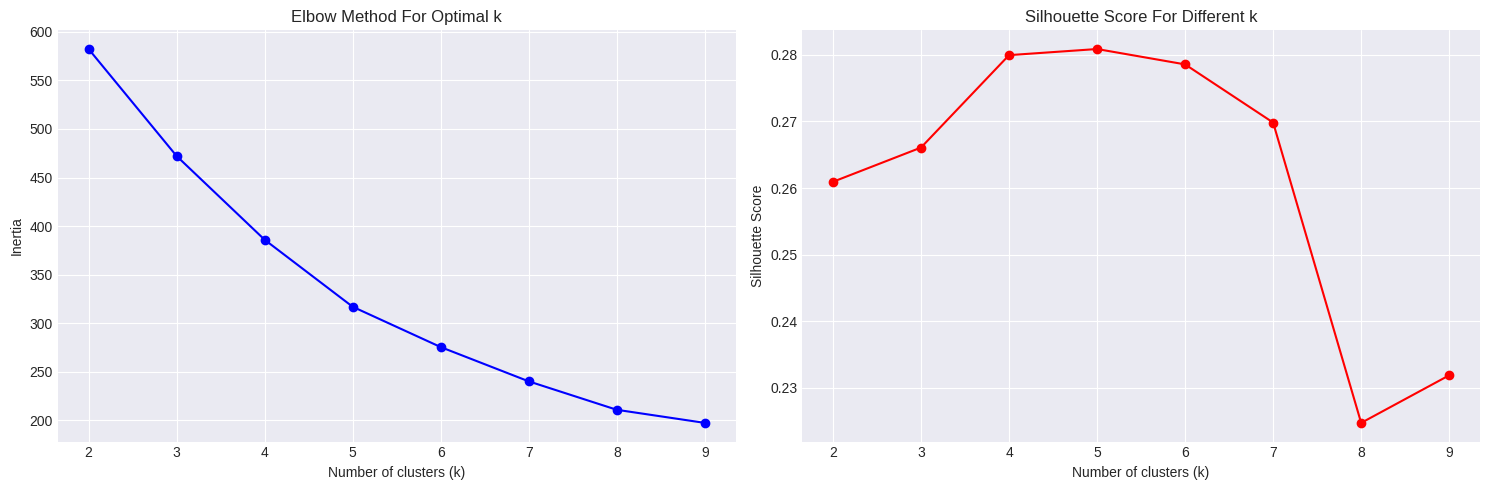

K-means clustering completed with 4 clusters

Cluster sizes:
kmeans_cluster
0    58
1     4
2     1
3    48
Name: count, dtype: int64


In [6]:
## 5. K-means Clustering

# Determine optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(K, inertias, 'bo-')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method For Optimal k')
ax1.grid(True)

ax2.plot(K, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score For Different k')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Perform K-means with optimal k (let's use k=4 based on the elbow)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
transition_df['kmeans_cluster'] = kmeans_labels

print(f"K-means clustering completed with {optimal_k} clusters")
print("\nCluster sizes:")
print(transition_df['kmeans_cluster'].value_counts().sort_index())

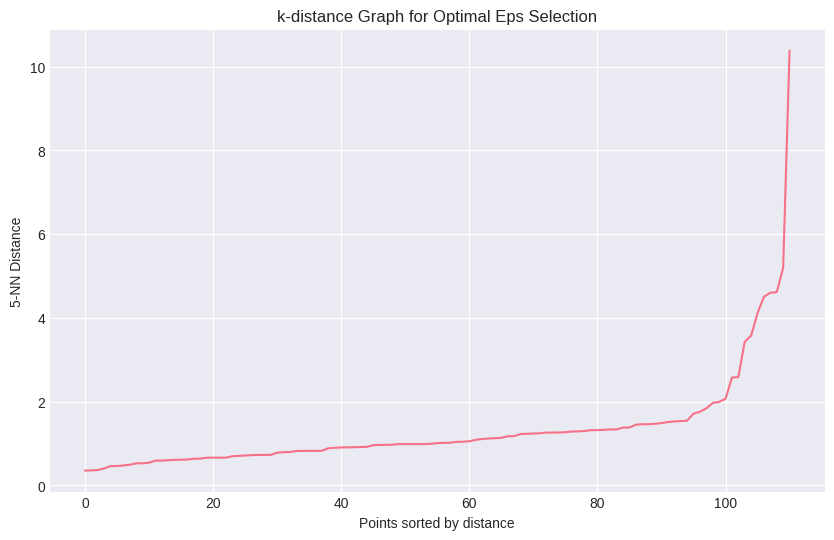

DBSCAN found 1 clusters
Number of noise points: 12

DBSCAN cluster sizes:
-1    12
 0    99
Name: count, dtype: int64


In [7]:
## 6. DBSCAN Clustering

# Find optimal eps using k-distance graph
from sklearn.neighbors import NearestNeighbors

# Calculate k-distances
k = 5  # MinPts parameter
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:, k-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.ylabel(f'{k}-NN Distance')
plt.xlabel('Points sorted by distance')
plt.title('k-distance Graph for Optimal Eps Selection')
plt.grid(True)
plt.show()

# Perform DBSCAN clustering
eps = 1.5  # Based on k-distance graph
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add DBSCAN labels to dataframe
transition_df['dbscan_cluster'] = dbscan_labels

# Analyze DBSCAN results
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN found {n_clusters} clusters")
print(f"Number of noise points: {n_noise}")
print("\nDBSCAN cluster sizes:")
print(pd.Series(dbscan_labels).value_counts().sort_index())

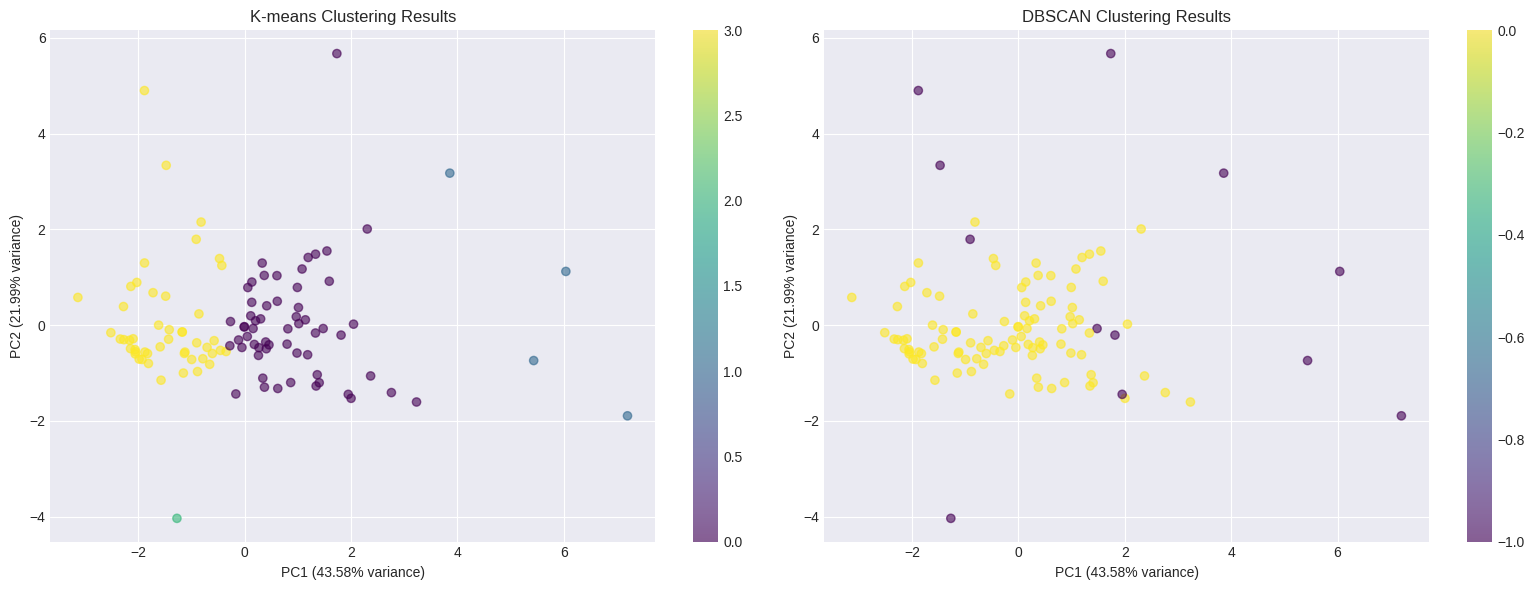

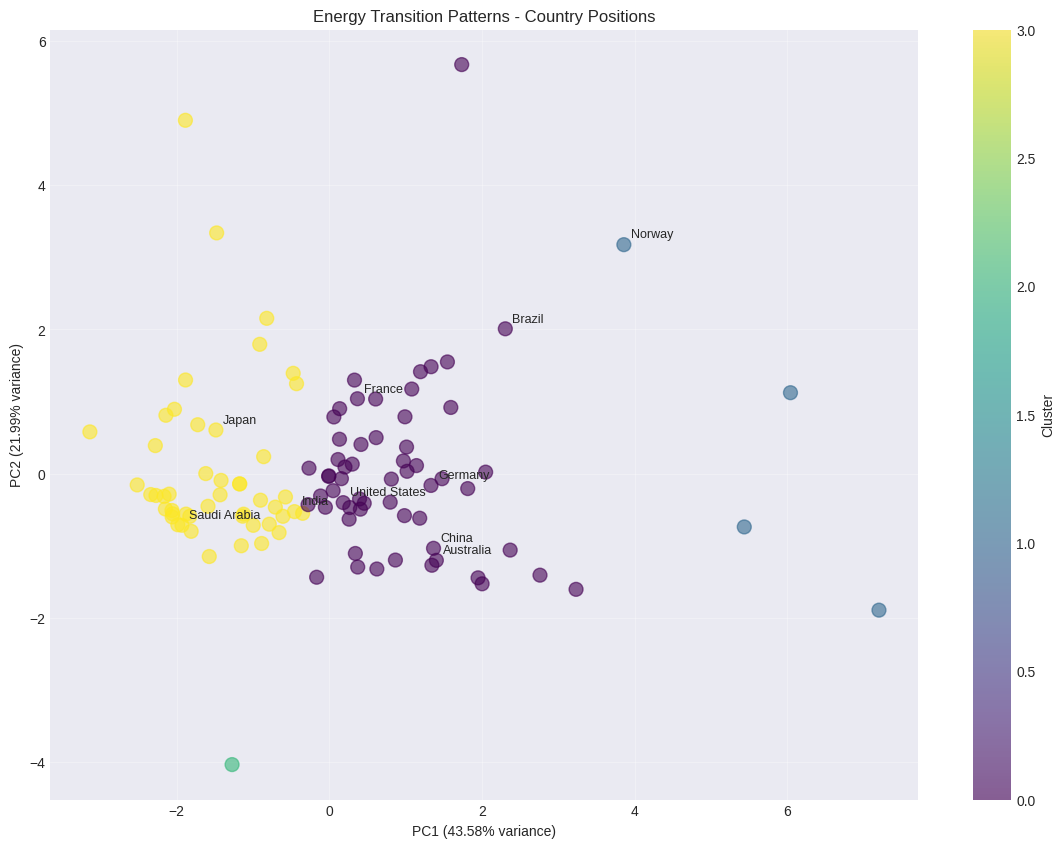

In [8]:
# 7. Visualize Clustering Results

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# K-means visualization
scatter1 = ax1.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    c=kmeans_labels, 
    cmap='viridis', 
    alpha=0.6
)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax1.set_title('K-means Clustering Results')
plt.colorbar(scatter1, ax=ax1)

# DBSCAN visualization
scatter2 = ax2.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    c=dbscan_labels, 
    cmap='viridis', 
    alpha=0.6
)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax2.set_title('DBSCAN Clustering Results')
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

# Annotate countries on PCA plot
plt.figure(figsize=(14, 10))
plt.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    c=kmeans_labels, 
    cmap='viridis', 
    alpha=0.6, 
    s=100
)

# Annotate selected countries
countries_to_annotate = [
    'United States', 
    'China', 
    'Germany', 
    'India', 
    'Brazil',
    'Norway', 
    'Saudi Arabia', 
    'Japan', 
    'Australia', 
    'France'
]

for i, country in enumerate(transition_df['country']):
    if country in countries_to_annotate:
        plt.annotate(
            country, 
            (X_pca[i, 0], X_pca[i, 1]),
            xytext=(5, 5), 
            textcoords='offset points', 
            fontsize=9
        )

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Energy Transition Patterns - Country Positions')
plt.colorbar(label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# Create cluster profiles
def create_cluster_profiles(df, cluster_col, features):
    """Create statistical profiles for each cluster"""
    profiles = []
    
    for cluster in sorted(df[cluster_col].unique()):
        if cluster == -1:  # Skip noise points for DBSCAN
            continue
            
        cluster_data = df[df[cluster_col] == cluster]
        profile = {'cluster': cluster, 'size': len(cluster_data)}
        
        # Calculate statistics for each feature
        for feature in features:
            profile[f'{feature}_mean'] = cluster_data[feature].mean()
            profile[f'{feature}_std'] = cluster_data[feature].std()
        
        # Get example countries
        profile['example_countries'] = ', '.join(cluster_data['country'].head(5).tolist())
        
        profiles.append(profile)
    
    return pd.DataFrame(profiles)

# Create profiles for K-means clusters
kmeans_profiles = create_cluster_profiles(transition_df, 'kmeans_cluster', clustering_features)
print("K-means Cluster Profiles:")
kmeans_profiles

K-means Cluster Profiles:


,cluster,size,renewable_growth_rate_mean,renewable_growth_rate_std,fossil_reduction_rate_mean,fossil_reduction_rate_std,energy_intensity_improvement_mean,energy_intensity_improvement_std,low_carbon_change_mean,low_carbon_change_std,solar_wind_growth_mean,solar_wind_growth_std,current_renewable_share_mean,current_renewable_share_std,current_fossil_share_mean,current_fossil_share_std,example_countries
0,0,58,1.394366,3.165690,0.069847,0.038056,0.163180,0.159961,5.931069,3.337194,5.136517,2.889060,19.938379,12.341875,74.925690,12.296006,"Asia, Asia Pacific (EI), Australia, Austria, B..."
1,1,4,0.757525,0.713482,0.261775,0.079935,0.228614,0.084657,15.409750,9.096673,11.913250,5.148885,49.442750,15.314634,40.313000,14.998966,"Denmark, Finland, Norway, Sweden"
2,2,1,281.200000,NaN,0.050633,NaN,0.125504,NaN,5.063000,NaN,1.403000,NaN,1.411000,NaN,94.932000,NaN,United Arab Emirates
3,3,48,1.172714,2.925652,-0.002943,0.052674,0.025009,0.243986,0.193667,3.358418,1.393292,1.478032,8.695479,10.577215,90.339958,10.708029,"Africa, Africa (EI), Algeria, Argentina, Azerb..."


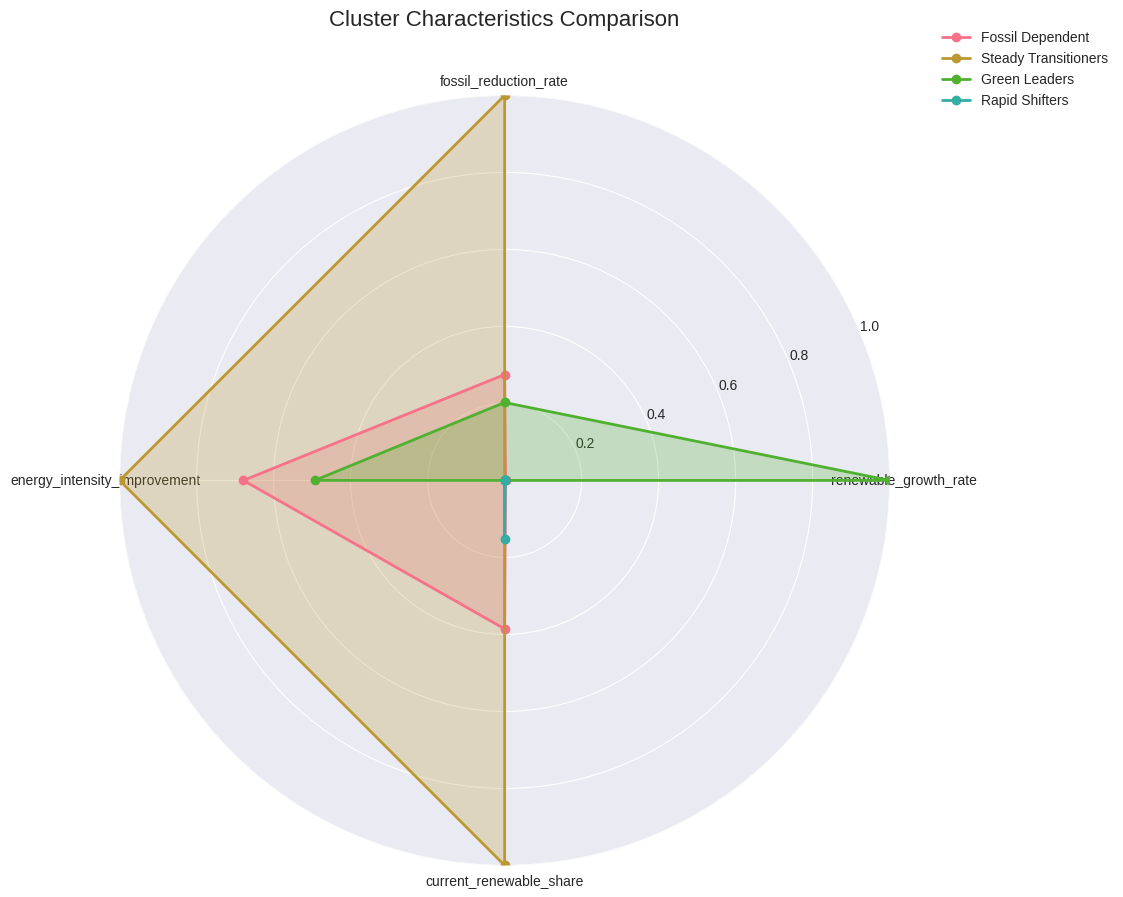

In [10]:
# Visualize cluster characteristics with radar chart
from math import pi

def create_radar_chart(df, cluster_col, features, cluster_names=None):
    """Create radar chart for cluster characteristics"""
    
    # Calculate mean values for each cluster
    cluster_means = df.groupby(cluster_col)[features].mean()
    
    # Normalize to 0-1 scale for radar chart
    cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
    
    # Set up the radar chart
    categories = features
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Plot each cluster
    for idx, (cluster, values) in enumerate(cluster_means_norm.iterrows()):
        if cluster == -1:  # Skip noise points
            continue
            
        values = values.tolist()
        values += values[:1]
        
        cluster_name = cluster_names[cluster] if cluster_names else f'Cluster {cluster}'
        ax.plot(angles, values, 'o-', linewidth=2, label=cluster_name)
        ax.fill(angles, values, alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=10)
    ax.set_ylim(0, 1)
    ax.set_title('Cluster Characteristics Comparison', size=16, y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.grid(True)
    
    return fig

# Define cluster names based on characteristics
cluster_names = {
    0: 'Fossil Dependent',
    1: 'Steady Transitioners',
    2: 'Green Leaders',
    3: 'Rapid Shifters'
}

# Create radar chart
radar_fig = create_radar_chart(transition_df, 'kmeans_cluster', 
                              ['renewable_growth_rate', 'fossil_reduction_rate', 
                               'energy_intensity_improvement', 'current_renewable_share'], 
                              cluster_names)
plt.show()

In [11]:
# Classify countries as developed/developing based on GDP per capita
# Using World Bank threshold: $12,000 GDP per capita
gdp_threshold = 12000
transition_df['development_status'] = transition_df['gdp_per_capita'].apply(
    lambda x: 'Developed' if x >= gdp_threshold else 'Developing'
)

# Handle missing GDP data
transition_df.loc[transition_df['gdp_per_capita'].isna(), 'development_status'] = 'Unknown'

print("Development status distribution:")
print(transition_df['development_status'].value_counts())

Development status distribution:
development_status
Developed     66
Developing    45
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

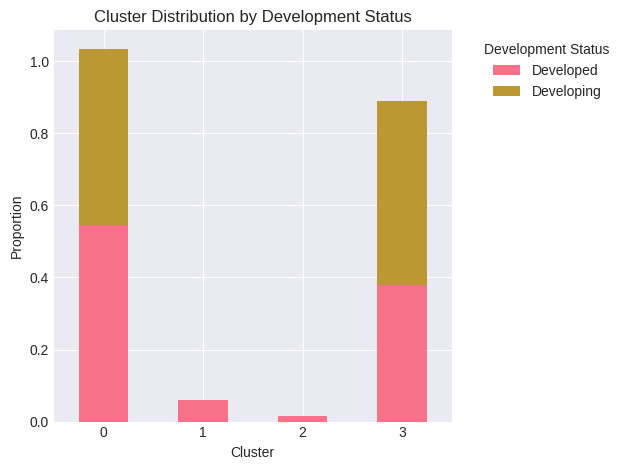

In [12]:
# Analyze cluster distribution by development status
cluster_dev_crosstab = pd.crosstab(transition_df['kmeans_cluster'], 
                                   transition_df['development_status'], 
                                   normalize='columns')

# Visualize
plt.figure(figsize=(10, 6))
cluster_dev_crosstab.plot(kind='bar', stacked=True)
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.title('Cluster Distribution by Development Status')
plt.legend(title='Development Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

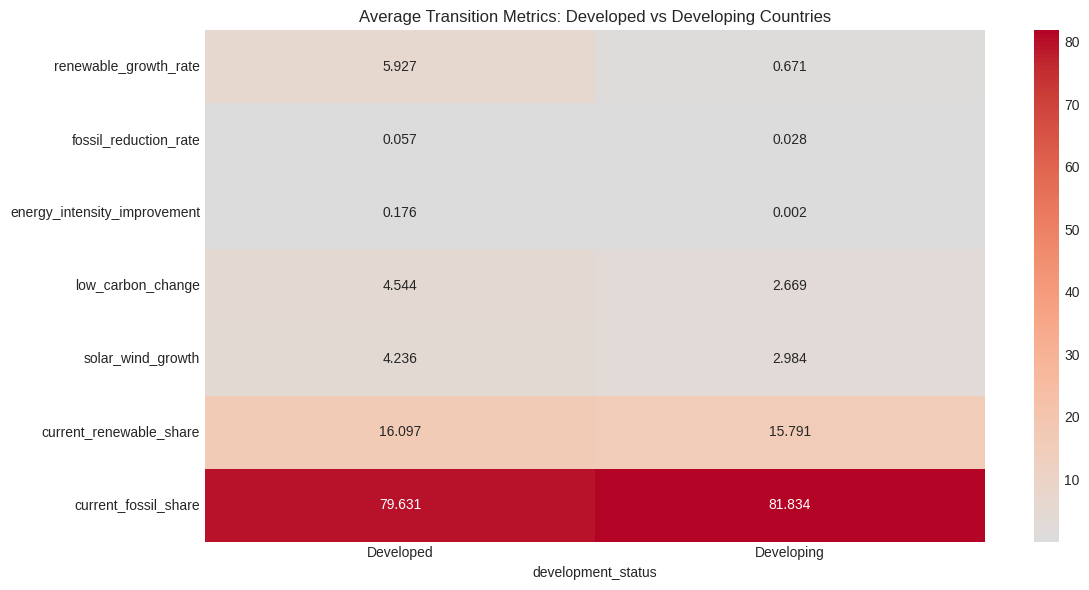

In [13]:
# Statistical comparison between developed and developing countries
dev_comparison = transition_df[transition_df['development_status'].isin(['Developed', 'Developing'])].groupby('development_status')[clustering_features].mean()

# Create comparison heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(dev_comparison.T, annot=True, fmt='.3f', cmap='coolwarm', center=0)
plt.title('Average Transition Metrics: Developed vs Developing Countries')
plt.tight_layout()
plt.show()

In [14]:
# Analyze countries identified as noise by DBSCAN
noise_countries = transition_df[transition_df['dbscan_cluster'] == -1].copy()

print(f"Countries with unique transition patterns (DBSCAN noise points): {len(noise_countries)}")
print("\nThese countries and their characteristics:")
print(noise_countries[['country', 'renewable_growth_rate', 'fossil_reduction_rate', 
                       'current_renewable_share', 'development_status']].sort_values('current_renewable_share', ascending=False))

Countries with unique transition patterns (DBSCAN noise points): 12

These countries and their characteristics:
                      country  renewable_growth_rate  fossil_reduction_rate  \
38                    Iceland              -0.011704              -0.057335   
64                     Norway               0.077659               0.141896   
94                     Sweden               0.403104               0.301744   
74   Other South America (EI)              -0.184828              -0.262146   
23                    Denmark               1.724371               0.303656   
69             Other CIS (EI)              -0.137750              -0.120163   
31                    Finland               0.824966               0.299802   
25                    Ecuador               0.877915               0.156594   
107                 Venezuela               0.252139               0.067636   
108                   Vietnam               0.816955               0.132231   
101                

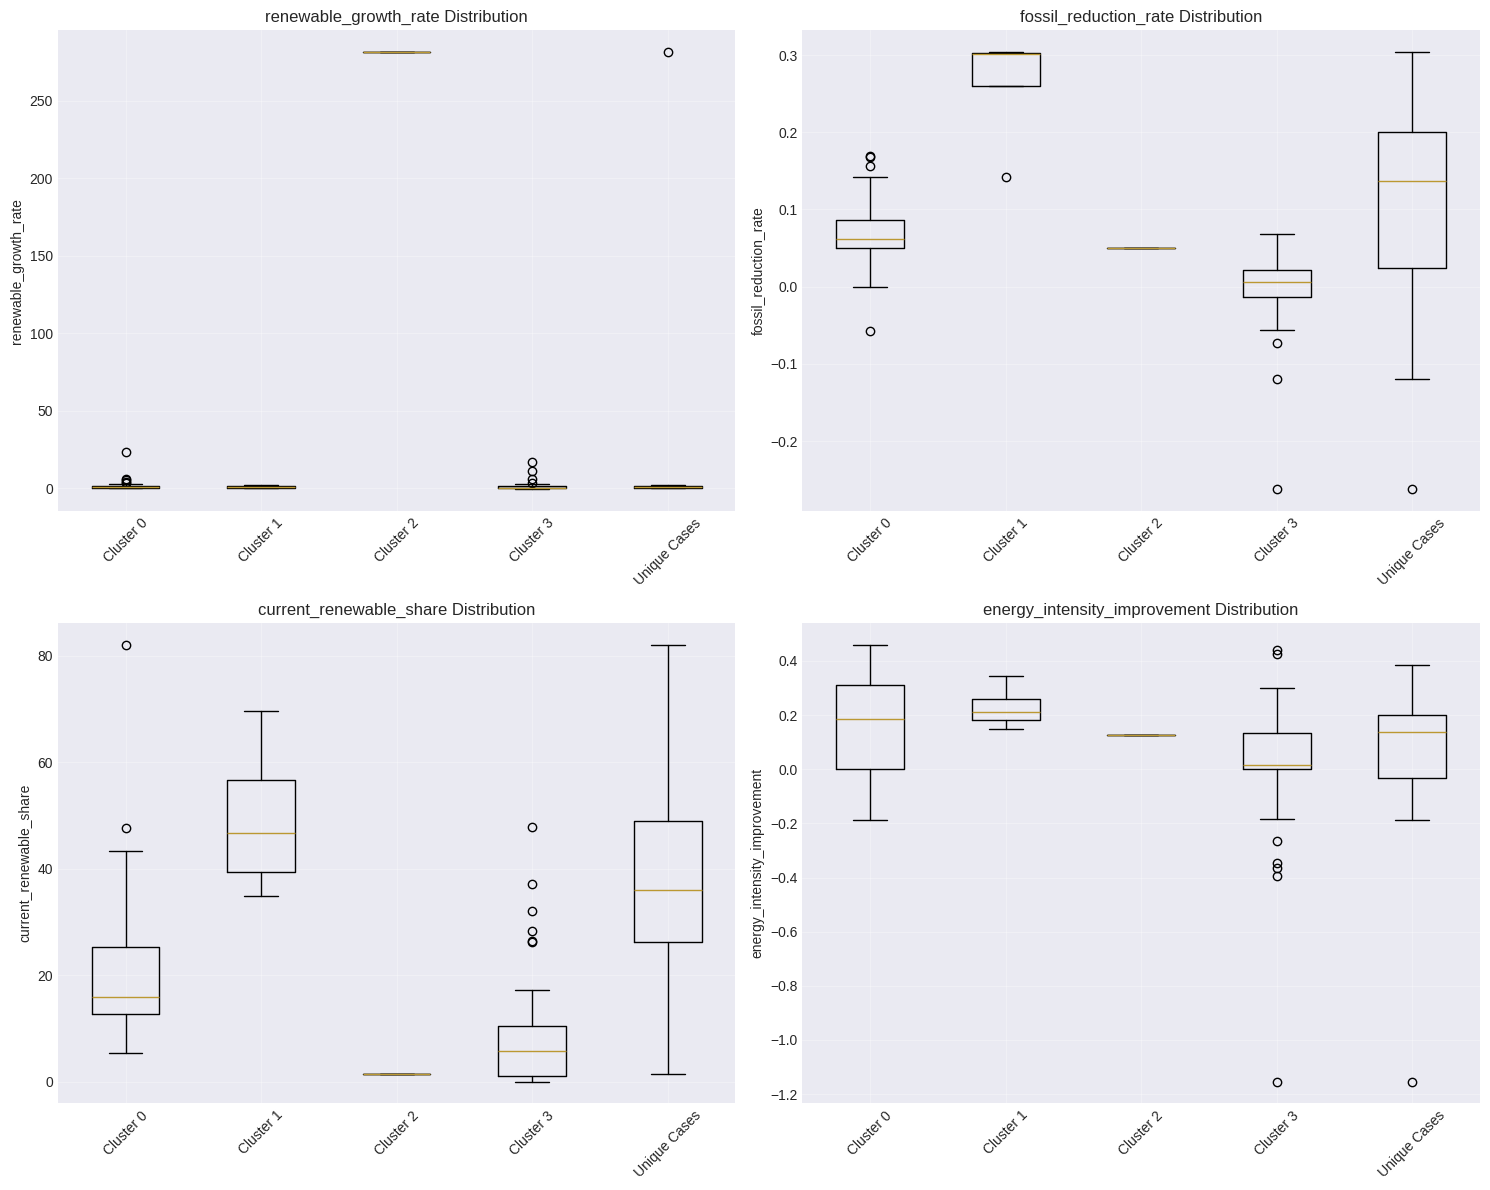

In [15]:
# Compare noise countries with main clusters
if len(noise_countries) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    features_to_compare = ['renewable_growth_rate', 'fossil_reduction_rate', 
                          'current_renewable_share', 'energy_intensity_improvement']
    
    for i, feature in enumerate(features_to_compare):
        # Box plot comparing clusters and noise
        data_to_plot = []
        labels = []
        
        for cluster in sorted(transition_df['kmeans_cluster'].unique()):
            cluster_data = transition_df[transition_df['kmeans_cluster'] == cluster][feature].dropna()
            data_to_plot.append(cluster_data)
            labels.append(f'Cluster {cluster}')
        
        # Add noise points
        noise_data = noise_countries[feature].dropna()
        if len(noise_data) > 0:
            data_to_plot.append(noise_data)
            labels.append('Unique Cases')
        
        axes[i].boxplot(data_to_plot, labels=labels)
        axes[i].set_title(f'{feature} Distribution')
        axes[i].set_ylabel(feature)
        axes[i].grid(True, alpha=0.3)
        
        # Rotate x labels if needed
        if len(labels) > 4:
            axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

In [16]:
# Create summary report
def create_summary_report(df, cluster_col='kmeans_cluster'):
    """Create a comprehensive summary of transition patterns"""
    
    print("=== ENERGY TRANSITION PATTERN ANALYSIS SUMMARY ===\n")
    
    # 1. Overall patterns
    print("1. IDENTIFIED TRANSITION PATTERNS:")
    for cluster in sorted(df[cluster_col].unique()):
        if cluster == -1:
            continue
        cluster_countries = df[df[cluster_col] == cluster]
        cluster_name = cluster_names.get(cluster, f"Cluster {cluster}")
        print(f"\n{cluster_name} ({len(cluster_countries)} countries):")
        print(f"  - Average renewable share: {cluster_countries['current_renewable_share'].mean():.1f}%")
        print(f"  - Average fossil reduction: {cluster_countries['fossil_reduction_rate'].mean():.1%}")
        print(f"  - Example countries: {', '.join(cluster_countries['country'].head(3).tolist())}")
    
    # 2. Development divide
    print("\n\n2. DEVELOPED vs DEVELOPING COUNTRIES:")
    dev_stats = df[df['development_status'].isin(['Developed', 'Developing'])].groupby('development_status').agg({
        'renewable_growth_rate': 'mean',
        'fossil_reduction_rate': 'mean',
        'current_renewable_share': 'mean'
    })
    print(dev_stats)
    
    # 3. Special cases
    print("\n\n3. COUNTRIES WITH UNIQUE PATTERNS:")
    unique_countries = df[df['dbscan_cluster'] == -1]
    if len(unique_countries) > 0:
        for _, country in unique_countries.iterrows():
            print(f"  - {country['country']}: {country['current_renewable_share']:.1f}% renewable")
    
    # 4. Policy recommendations
    print("\n\n4. KEY INSIGHTS FOR POLICY:")
    print("  - Green Leaders show that >80% renewable energy is achievable")
    print("  - Rapid Shifters demonstrate that fast transition is possible with right policies")
    print("  - Developing countries need different support than developed nations")
    print("  - Special attention needed for Fossil Dependent countries")

# Generate summary report
create_summary_report(transition_df)

=== ENERGY TRANSITION PATTERN ANALYSIS SUMMARY ===

1. IDENTIFIED TRANSITION PATTERNS:

Fossil Dependent (58 countries):
  - Average renewable share: 19.9%
  - Average fossil reduction: 7.0%
  - Example countries: Asia, Asia Pacific (EI), Australia

Steady Transitioners (4 countries):
  - Average renewable share: 49.4%
  - Average fossil reduction: 26.2%
  - Example countries: Denmark, Finland, Norway

Green Leaders (1 countries):
  - Average renewable share: 1.4%
  - Average fossil reduction: 5.1%
  - Example countries: United Arab Emirates

Rapid Shifters (48 countries):
  - Average renewable share: 8.7%
  - Average fossil reduction: -0.3%
  - Example countries: Africa, Africa (EI), Algeria


2. DEVELOPED vs DEVELOPING COUNTRIES:
                    renewable_growth_rate  fossil_reduction_rate  \
development_status                                                 
Developed                        5.927383               0.057030   
Developing                       0.670808             

In [17]:
# Export results for further analysis
output_df = transition_df[['country', 'kmeans_cluster', 'dbscan_cluster', 'development_status'] + clustering_features]
output_df['cluster_name'] = output_df['kmeans_cluster'].map(cluster_names)

# Save to CSV
output_df.to_csv('energy_transition_clusters.csv', index=False)
print("\nResults saved to 'energy_transition_clusters.csv'")

# Display final clustering results
print("\nFinal clustering results (first 20 countries):")
output_df.head(20)


Results saved to 'energy_transition_clusters.csv'

Final clustering results (first 20 countries):


,country,kmeans_cluster,dbscan_cluster,development_status,renewable_growth_rate,fossil_reduction_rate,energy_intensity_improvement,low_carbon_change,solar_wind_growth,current_renewable_share,current_fossil_share,cluster_name
0,Africa,3,0,Developing,0.324228,0.019574,0.000000,1.810,1.593,8.920,90.661,Rapid Shifters
1,Africa (EI),3,0,Developing,0.324228,0.019574,0.000000,1.810,1.593,8.920,90.661,Rapid Shifters
2,Algeria,3,0,Developed,1.111111,0.001201,-0.264887,0.120,0.217,0.228,99.772,Rapid Shifters
3,Argentina,3,0,Developed,0.082762,0.007134,-0.042743,0.619,4.217,12.010,86.146,Rapid Shifters
4,Asia,0,0,Developing,1.025413,0.059558,0.000000,5.479,4.157,11.397,86.515,Fossil Dependent
5,Asia Pacific (EI),0,0,Developing,1.071019,0.069329,0.000000,6.305,4.812,13.006,84.638,Fossil Dependent
6,Australia,0,0,Developed,2.240460,0.095494,0.186430,9.159,9.047,13.247,86.753,Fossil Dependent
7,Austria,0,0,Developed,0.166739,0.071845,0.230707,5.021,5.877,35.134,64.866,Fossil Dependent
8,Azerbaijan,3,0,Developed,-0.688363,-0.051979,-0.347191,-4.833,0.167,2.188,97.812,Rapid Shifters
9,Bangladesh,3,0,Developing,-0.169065,-0.001422,0.049363,-0.141,0.262,0.693,99.307,Rapid Shifters


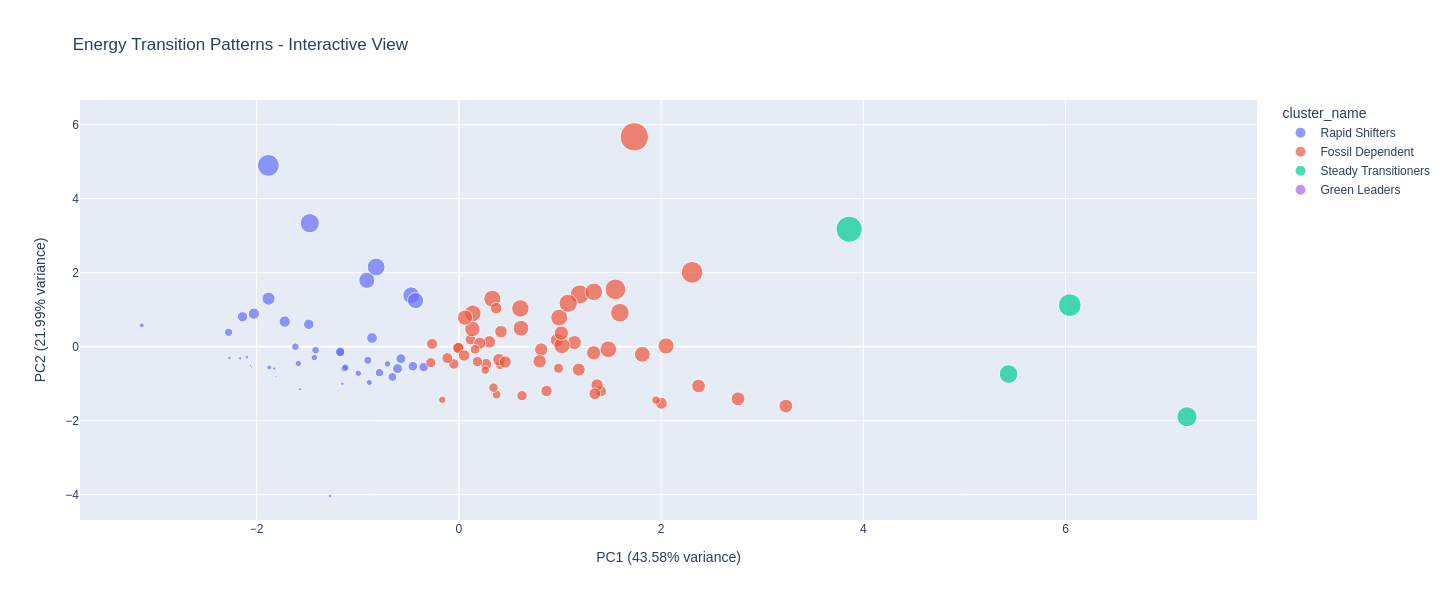

In [18]:
# Create an interactive scatter plot using plotly
import plotly.express as px

# Prepare data for interactive plot
plot_df = transition_df.copy()
plot_df['pca1'] = X_pca[:, 0]
plot_df['pca2'] = X_pca[:, 1]
plot_df['cluster_name'] = plot_df['kmeans_cluster'].map(cluster_names)

# Handle NaN values in size column
# Option 1: Fill NaN with median value
plot_df['size_for_plot'] = plot_df['current_renewable_share'].fillna(plot_df['current_renewable_share'].median())

# Create interactive scatter plot
fig = px.scatter(plot_df, 
                 x='pca1', 
                 y='pca2', 
                 color='cluster_name',
                 hover_data=['country', 'current_renewable_share', 'fossil_reduction_rate', 'development_status'],
                 hover_name='country',
                 title='Energy Transition Patterns - Interactive View',
                 labels={'pca1': f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)',
                         'pca2': f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)'},
                 size='size_for_plot',
                 size_max=20)

fig.update_layout(height=600, width=900)
fig.show()